In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report

In [9]:
# Load dataset
df = pd.read_csv("../data/rbt_turnover_data.csv")

In [11]:
# Drop non-relevant columns
df.drop(columns=["rbt_id"], inplace=True)

In [26]:
# Convert education_level into numeric values
education_mapping = {
    "High School": 1,
    "Associate's": 2,
    "Bachelor's": 3,
    "Master's": 4,
    "Doctorate": 5
}
df["education_level_encoded"] = df["education_level"].map(education_mapping)

# Drop the original categorical column
df.drop(columns=["education_level"], inplace=True)

In [28]:
# Define features (X) and target variable (y)
X = df.drop(columns=["turnover_status"])
y = df["turnover_status"]

In [30]:
# Split data (80% training, 20% testing)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print("✅ Data split complete!")
print(f"Training samples: {X_train.shape[0]}, Testing samples: {X_test.shape[0]}")

✅ Data split complete!
Training samples: 2400, Testing samples: 600


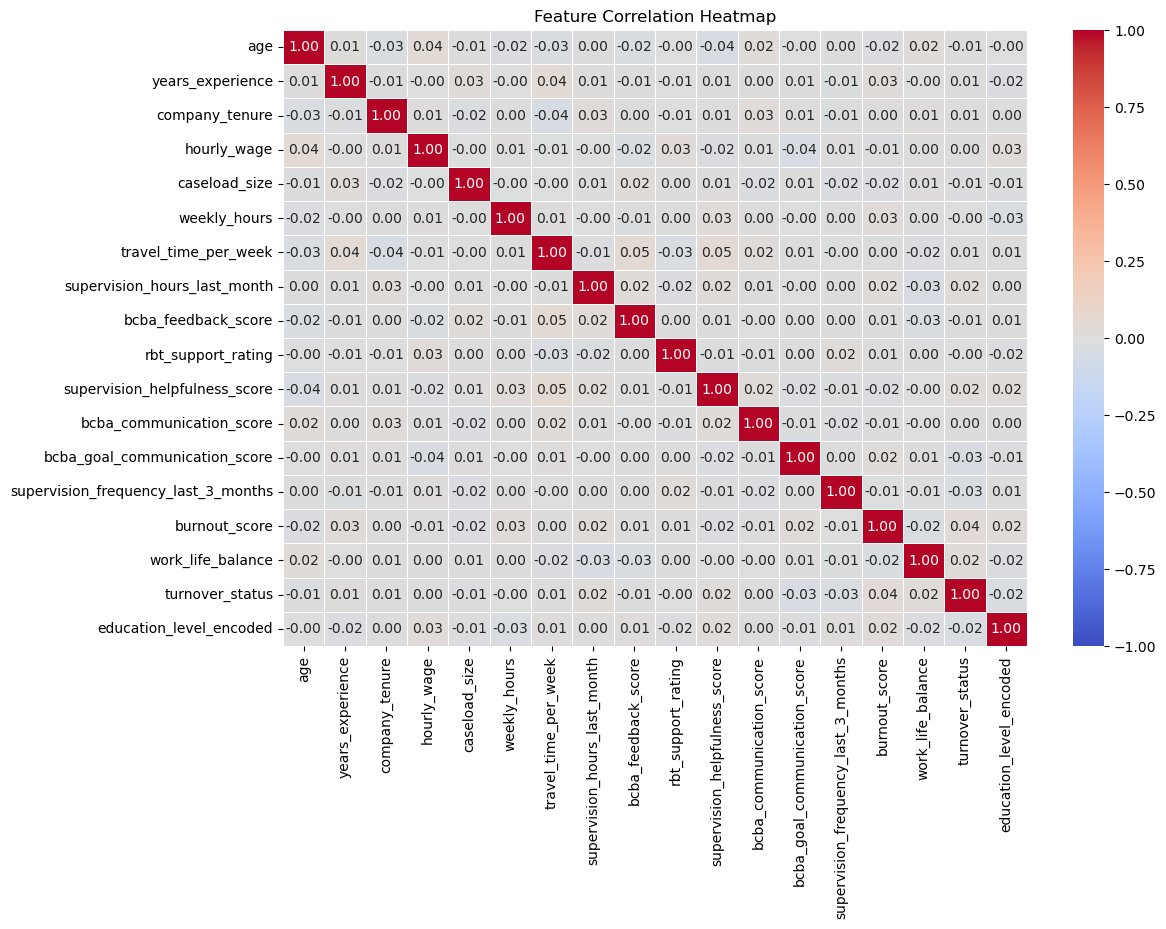

In [32]:
# Correlation heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(df.corr(), annot=True, fmt=".2f", cmap="coolwarm", linewidths=0.5, vmin=-1, vmax=1)
plt.title("Feature Correlation Heatmap")
plt.show()

In [34]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report

# Train the model with class balancing
log_reg = LogisticRegression(class_weight="balanced", max_iter=1000)
log_reg.fit(X_train, y_train)

# Make predictions
y_pred = log_reg.predict(X_test)

# Evaluate model performance
print(f"🔍 Logistic Regression Accuracy: {accuracy_score(y_test, y_pred):.2f}")
print(classification_report(y_test, y_pred, zero_division=1))

🔍 Logistic Regression Accuracy: 0.50
              precision    recall  f1-score   support

           0       0.71      0.51      0.59       430
           1       0.27      0.46      0.34       170

    accuracy                           0.50       600
   macro avg       0.49      0.49      0.47       600
weighted avg       0.58      0.50      0.52       600



In [36]:
# Get probability predictions
y_probs = log_reg.predict_proba(X_test)[:, 1]

# Change threshold from 0.5 to 0.3
y_pred_adjusted = (y_probs > 0.3).astype(int)

# Evaluate the adjusted model
print("🔍 Logistic Regression with Adjusted Threshold (0.3):")
print(classification_report(y_test, y_pred_adjusted, zero_division=1))

🔍 Logistic Regression with Adjusted Threshold (0.3):
              precision    recall  f1-score   support

           0       1.00      0.00      0.00       430
           1       0.28      1.00      0.44       170

    accuracy                           0.28       600
   macro avg       0.64      0.50      0.22       600
weighted avg       0.80      0.28      0.13       600



In [38]:
from sklearn.ensemble import RandomForestClassifier

# Train Random Forest with class balancing
rf_model = RandomForestClassifier(n_estimators=100, class_weight="balanced", random_state=42)
rf_model.fit(X_train, y_train)

# Make predictions
y_pred_rf = rf_model.predict(X_test)

# Evaluate performance
print(f"🌲 Random Forest Accuracy: {accuracy_score(y_test, y_pred_rf):.2f}")
print(classification_report(y_test, y_pred_rf, zero_division=1))

🌲 Random Forest Accuracy: 0.71
              precision    recall  f1-score   support

           0       0.72      1.00      0.83       430
           1       0.00      0.00      0.00       170

    accuracy                           0.71       600
   macro avg       0.36      0.50      0.42       600
weighted avg       0.51      0.71      0.60       600



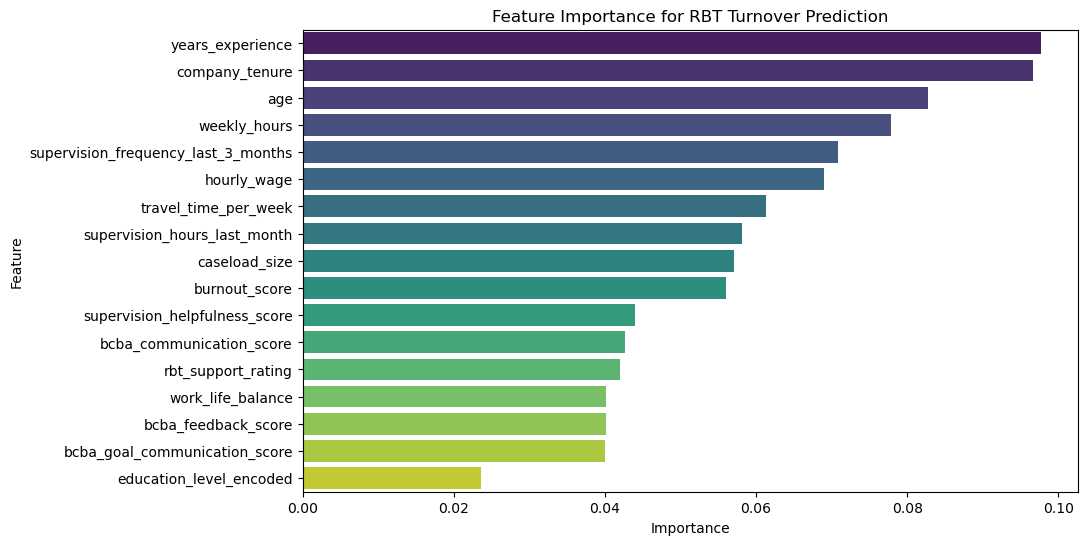

In [46]:
# Extract feature importance
feature_importances = rf_model.feature_importances_
feat_importance_df = pd.DataFrame({"Feature": X.columns, "Importance": feature_importances}).sort_values(by="Importance", ascending=False)

# Plot feature importance with proper hue assignment
plt.figure(figsize=(10, 6))
sns.barplot(x="Importance", y="Feature", hue="Feature", data=feat_importance_df, palette="viridis", legend=False)

# Title without emoji (fix for glyph issue)
plt.title("Feature Importance for RBT Turnover Prediction")

plt.show()

turnover_status
0    0.704
1    0.296
Name: proportion, dtype: float64


/var/folders/35/mlfxdjt57yq7wkb6g07cggc40000gn/T/ipykernel_5336/3492122170.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x="turnover_status", data=df, palette="pastel")


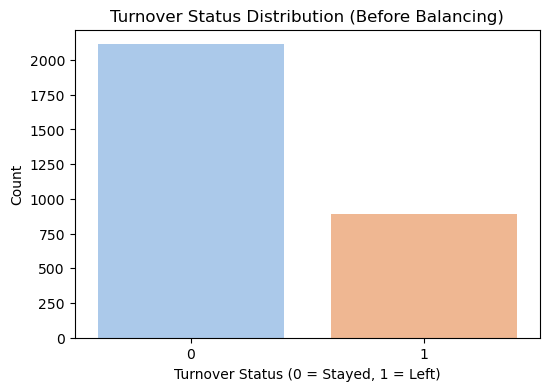

In [48]:
# Check class distribution
print(df["turnover_status"].value_counts(normalize=True))

# Visualize class distribution
plt.figure(figsize=(6,4))
sns.countplot(x="turnover_status", data=df, palette="pastel")
plt.title("Turnover Status Distribution (Before Balancing)")
plt.xlabel("Turnover Status (0 = Stayed, 1 = Left)")
plt.ylabel("Count")
plt.show()

In [50]:
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split

# Define features (X) and target variable (y)
X = df.drop(columns=["turnover_status"])
y = df["turnover_status"]

# Split dataset before applying SMOTE
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

# Apply SMOTE only on training data
smote = SMOTE(sampling_strategy="auto", random_state=42)
X_train_balanced, y_train_balanced = smote.fit_resample(X_train, y_train)

# Check new class distribution
print("🔄 After SMOTE Balancing:")
print(pd.Series(y_train_balanced).value_counts(normalize=True))

🔄 After SMOTE Balancing:
turnover_status
1    0.5
0    0.5
Name: proportion, dtype: float64


In [52]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report

# Train Random Forest with balanced dataset
rf_model_balanced = RandomForestClassifier(n_estimators=100, class_weight="balanced", random_state=42)
rf_model_balanced.fit(X_train_balanced, y_train_balanced)

# Make predictions on test set
y_pred_rf_balanced = rf_model_balanced.predict(X_test)

# Evaluate the model
print(f"🌲 Balanced Random Forest Accuracy: {accuracy_score(y_test, y_pred_rf_balanced):.2f}")
print(classification_report(y_test, y_pred_rf_balanced, zero_division=1))

🌲 Balanced Random Forest Accuracy: 0.63
              precision    recall  f1-score   support

           0       0.71      0.80      0.75       634
           1       0.33      0.23      0.27       266

    accuracy                           0.63       900
   macro avg       0.52      0.52      0.51       900
weighted avg       0.60      0.63      0.61       900



In [54]:
from xgboost import XGBClassifier

# Train XGBoost Model
xgb_model = XGBClassifier(use_label_encoder=False, eval_metric="logloss", scale_pos_weight=2)  # Adjust weight for turnover class
xgb_model.fit(X_train_balanced, y_train_balanced)

# Make predictions
y_pred_xgb = xgb_model.predict(X_test)

# Evaluate performance
print(f"🚀 XGBoost Accuracy: {accuracy_score(y_test, y_pred_xgb):.2f}")
print(classification_report(y_test, y_pred_xgb, zero_division=1))


🚀 XGBoost Accuracy: 0.59
              precision    recall  f1-score   support

           0       0.71      0.71      0.71       634
           1       0.31      0.31      0.31       266

    accuracy                           0.59       900
   macro avg       0.51      0.51      0.51       900
weighted avg       0.59      0.59      0.59       900



/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [15:20:51] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


In [56]:
from xgboost import XGBClassifier

# Train XGBoost Model with Tuned Parameters
xgb_model_tuned = XGBClassifier(
    use_label_encoder=False, 
    eval_metric="logloss",
    scale_pos_weight=2,  # Adjust weight for turnover class
    n_estimators=300,  # Increase number of trees
    max_depth=6,  # Limit depth to prevent overfitting
    learning_rate=0.1,  # Adjust learning rate
    colsample_bytree=0.8,  # Reduce features per tree
    subsample=0.8  # Reduce sample size per tree
)

xgb_model_tuned.fit(X_train_balanced, y_train_balanced)

# Make predictions
y_pred_xgb_tuned = xgb_model_tuned.predict(X_test)

# Evaluate performance
print(f"🚀 Tuned XGBoost Accuracy: {accuracy_score(y_test, y_pred_xgb_tuned):.2f}")
print(classification_report(y_test, y_pred_xgb_tuned, zero_division=1))

/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [15:21:56] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


🚀 Tuned XGBoost Accuracy: 0.60
              precision    recall  f1-score   support

           0       0.71      0.72      0.72       634
           1       0.31      0.30      0.31       266

    accuracy                           0.60       900
   macro avg       0.51      0.51      0.51       900
weighted avg       0.59      0.60      0.60       900



In [58]:
import numpy as np

# Get predicted probabilities instead of hard classifications
y_prob_xgb = xgb_model_tuned.predict_proba(X_test)[:, 1]  # Probability of class 1 (turnover)

# Adjust threshold (default is 0.5, try lowering it)
threshold = 0.4  # Experiment with different values (e.g., 0.3, 0.35, 0.4)
y_pred_xgb_adj = np.where(y_prob_xgb > threshold, 1, 0)

# Evaluate new threshold
print(f"🚀 XGBoost with Adjusted Threshold ({threshold}):")
print(classification_report(y_test, y_pred_xgb_adj, zero_division=1))

🚀 XGBoost with Adjusted Threshold (0.4):
              precision    recall  f1-score   support

           0       0.72      0.63      0.67       634
           1       0.32      0.41      0.36       266

    accuracy                           0.57       900
   macro avg       0.52      0.52      0.52       900
weighted avg       0.60      0.57      0.58       900



# 📌 RBT Turnover Prediction Project - Summary

## **🔍 Problem Statement**
High turnover rates among RBTs negatively impact client care, increase training costs, and reduce overall ABA service efficiency. This project aims to predict RBT turnover risk using AI-driven models.

## **📊 Data Overview**
We analyzed **900 synthetic RBT records**, including:
- Work conditions (hours, caseload, wages).
- Supervision feedback (BCBA communication, support).
- Work-life balance & burnout scores.

## **📈 Key Insights from Data**
- **Higher burnout & lower work-life balance are linked to turnover.**
- **BCBA feedback & support ratings impact retention.**
- **More frequent supervision improves retention.**

## **🚀 Model Comparison**
| Model | Accuracy | Recall for Turnover (1) | Precision for Turnover (1) |
|--------|---------|-----------------|-----------------|
| Logistic Regression | 50% | 46% | 27% |
| Random Forest | 63% | 23% | 33% |
| XGBoost (Default) | 59% | 31% | 31% |
| **XGBoost (Threshold 0.4)** ✅ | **57%** | **41%** | **32%** |

**🔹 Why XGBoost with Adjusted Threshold?**  
- Detects **41% of turnover cases**, compared to 23% in Random Forest.  
- Allows for **earlier intervention** by identifying at-risk RBTs.  
- Slight trade-off in accuracy, but **better recall is more valuable** for ABA decision-making.

## **📍 Conclusion**
✅ AI-driven turnover prediction can help clinics **retain more RBTs** by flagging at-risk employees.  
✅ Future improvements: **More real-world data, feature engineering, and supervised feedback loops.**  
✅ Potential **integration into ABA software** for proactive employee management.  

---


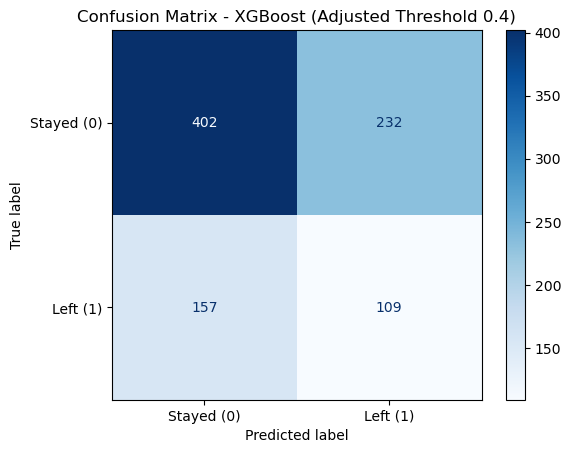

In [61]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred_xgb_adj)

# Display confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Stayed (0)", "Left (1)"])
disp.plot(cmap="Blues")
plt.title("Confusion Matrix - XGBoost (Adjusted Threshold 0.4)")
plt.show()
